In [1]:
import os
import sys
sys.path.append('/archive/bioinformatics/')
from DLLab.src.shared.distribution.DLLablib.preamble import notebook; notebook()

import glob
import re
import numpy as np
import pandas as pd
idx = pd.IndexSlice
from scipy import signal
import nibabel
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper', font_scale=1.4)
from DLLab.AlexTreacher.src import paths

import bids

Machine node: NucleusA250
Python interpreter: /project/bioinformatics/DLLab/shared/CondaEnvironments/Alex37General/bin/python 	
 ver 3.7.10 (default, Feb 26 2021, 18:47:35) 
[GCC 7.3.0]
Current dir: /endosome/archive/bioinformatics/DLLab/src/AlexTreacher/autism_DCG/notebooks
Conda env: /project/bioinformatics/DLLab/shared/CondaEnvironments/Alex37General


In [2]:
strDataPath = paths.strDataDir
strOutputDirABIDE1 = strDataPath+'/20210825_ABIDE_CPAC/ABIDEI/derivatives/CPAC/output/cpac_cpac-custom-nuisance'
strOutputDirABIDE2 = strDataPath+'/20210825_ABIDE_CPAC/ABIDEII/derivatives/CPAC/output/cpac_cpac-custom-nuisance'
strOutputPath = os.path.join(paths.strExperimentOutputDir,'Autism_DCG')

In [3]:
def fGetABIDEFromPath(strPath):
    strABIDE = re.findall('ABIDE([I]+)', strPath)[0]
    if strABIDE not in ['I','II']:
        raise ValueError(f'ABIDE {strABIDE} not recognized')
    return strABIDE.__len__()

In [4]:
#get all paths for framewise displacement
lFWDPaths = glob.glob(os.path.join(strOutputDirABIDE1, '*','func','*framewise-displacement-jenkinson.1D')) +\
            glob.glob(os.path.join(strOutputDirABIDE2, '*','func','*framewise-displacement-jenkinson.1D'))

In [5]:
lFWDPaths

['/archive/bioinformatics/DLLab/AlexTreacher/data/20210825_ABIDE_CPAC/ABIDEI/derivatives/CPAC/output/cpac_cpac-custom-nuisance/sub-0050143_ses-1/func/sub-0050143_ses-1_task-rest_run-3_framewise-displacement-jenkinson.1D',
 '/archive/bioinformatics/DLLab/AlexTreacher/data/20210825_ABIDE_CPAC/ABIDEI/derivatives/CPAC/output/cpac_cpac-custom-nuisance/sub-0050143_ses-1/func/sub-0050143_ses-1_task-rest_run-1_framewise-displacement-jenkinson.1D',
 '/archive/bioinformatics/DLLab/AlexTreacher/data/20210825_ABIDE_CPAC/ABIDEI/derivatives/CPAC/output/cpac_cpac-custom-nuisance/sub-0050143_ses-1/func/sub-0050143_ses-1_task-rest_run-2_framewise-displacement-jenkinson.1D',
 '/archive/bioinformatics/DLLab/AlexTreacher/data/20210825_ABIDE_CPAC/ABIDEI/derivatives/CPAC/output/cpac_cpac-custom-nuisance/sub-0051372_ses-1/func/sub-0051372_ses-1_task-rest_run-1_framewise-displacement-jenkinson.1D',
 '/archive/bioinformatics/DLLab/AlexTreacher/data/20210825_ABIDE_CPAC/ABIDEI/derivatives/CPAC/output/cpac_cpac-c

In [6]:
#get the FWD values for all subjects and set in a dataframe
dfFWD = pd.DataFrame()
for strPath in lFWDPaths:
    strSubject = re.findall('sub-([0-9A-Za-z]+)', strPath)[0]
    if strSubject.startswith('00'):
        strSubject = strSubject[2:]
    strABIDE = fGetABIDEFromPath(strPath)
    strSession = re.findall('ses-([0-9A-Za-z]+)', strPath)[0]
    strRun = re.findall('run-([0-9A-Za-z]+)', strPath)[0]
    pdsSubjectFWD = pd.read_csv(strPath, header=None)[0]
    pdsSubjectFWD.name=(strSubject,strABIDE,strSession,strRun,strPath)
    dfFWD = dfFWD.append(pdsSubjectFWD)
    
lIndexCols = ['subject','ABIDE','session','run','path']
dfFWD.index = pd.MultiIndex.from_tuples(dfFWD.index.tolist())
dfFWD.index.set_names(lIndexCols, inplace=True)

<AxesSubplot:>

(0.0, 2.0)

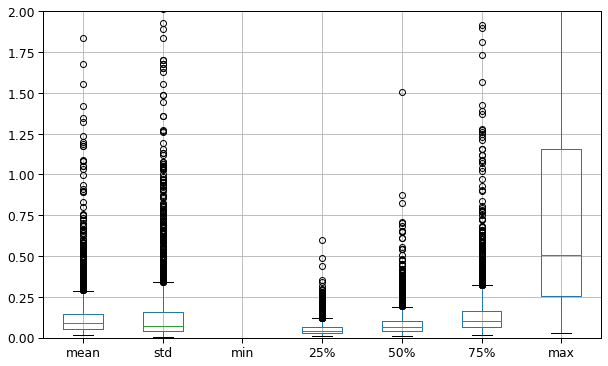

In [7]:
dfFWDStats = dfFWD.T.describe().T
#dfFWDStats.index.set_names(('subject','path'))
dfFWDStats.drop(columns='count').boxplot()
plt.ylim(0,2)

### Remove all ABIDE 2 5xxxx subjects (revisits from ABIDEII)

In [8]:
dfIndex = pd.DataFrame(dfFWDStats.index.tolist(), columns = dfFWDStats.index.names)
dfIndex = dfIndex[~((dfIndex['ABIDE'] == 2) & (dfIndex['subject'].apply(lambda x: x.startswith('5'))))]

In [9]:
dfFWDStats = dfFWDStats.loc[dfIndex.values.tolist()]

In [10]:
#make sure there are no 5xxxx subjects left in the ABIDEII data
set([x[0] for x in dfFWDStats.loc[idx[:,2,:,:,:]].index.get_level_values(0)])

{'2', '3'}

In [11]:
dfFWDStats.shape

(2045, 8)

### drop subjects that failed to create a ReHo map

In [12]:
dfFWDStats.reset_index(drop=False, inplace=True)

In [13]:
lFailedSubjects = []
for i, row in dfFWDStats.iterrows():
    strABIDENum = 'I'*int(row['ABIDE'])
    strSubject = row['subject']
    if row['ABIDE']==1:
        strSubject = '00'+strSubject
    strSession = row['session']
    strRun = row['run']
    strReHoPath = strDataPath+f'/20210825_ABIDE_CPAC/ABIDE{strABIDENum}/derivatives/CPAC/output/cpac_cpac-custom-nuisance/sub-{strSubject}_ses-{strSession}/func/sub-{strSubject}_ses-{strSession}_task-rest_run-{strRun}*_desc-1_reho.nii.gz'
    lPaths = glob.glob(strReHoPath)
    if lPaths.__len__() ==0:
        lFailedSubjects.append([strSubject,strABIDENum,strSession,strRun,row['path']])
        dfFWDStats.drop([i], inplace=True)
        
dfFWDStats.set_index(lIndexCols, inplace=True)

In [14]:
lFailedSubjects.__len__()

7

In [15]:
dfFWDStats.shape

(2038, 8)

### For each subject that has multiple scans, select the scan with the lowest FWD

In [16]:
#make the subject and path columns
dfFWDStats.reset_index(drop=False, inplace=True)
#sort on subject and mean performance
dfFWDStats.sort_values(['subject','mean'], ascending=True, inplace=True)
#drop duplicates, keeping the first (lowest mean FDW as it's ordered from above)
dfFWDStats.drop_duplicates('subject', keep='first', inplace=True)
#reset the index to subject and path
dfFWDStats.set_index(lIndexCols, inplace=True)

In [17]:
#make sure that each subject only has a single scan
assert pd.Series(dfFWDStats.index.get_level_values(0)).value_counts().sum() == dfFWDStats.shape[0]

In [18]:
dfFWDStats.shape

(1790, 8)

In [19]:
print(dfFWDStats.loc[idx[:,1,:,:,:],:].shape[0])
print(dfFWDStats.loc[idx[:,2,:,:,:],:].shape[0])

963
827


In [20]:
lFailedSubjects = []
dfDVARS = pd.DataFrame()
for i, row in dfFWDStats.iterrows():
    strSubject, strABIDE, strSession, strRun, strFWDPath = i
    if strABIDE == 1:
        strDVARSSearch = os.path.join(os.path.dirname(strFWDPath),f'sub-00{strSubject}_ses-{strSession}_task-rest_run-{strRun}*dvars.txt')
    else:
        strDVARSSearch = os.path.join(os.path.dirname(strFWDPath),f'sub-{strSubject}_ses-{strSession}_task-rest_run-{strRun}*dvars.txt')
    lDVARSPaths = glob.glob(strDVARSSearch)
    if not lDVARSPaths.__len__() == 1:
        print(strFWDPath)
        lFailedSubjects.append(strFWDPath)
        continue
    strPath = lDVARSPaths[0]
    pdsSubjectDVARS = pd.read_csv(strPath, header=None)[0]
    pdsSubjectDVARS.name= (strSubject, strABIDE, strSession, strRun, strPath)
    dfDVARS = dfDVARS.append(pdsSubjectDVARS)    
dfDVARS.index = pd.MultiIndex.from_tuples(dfDVARS.index.tolist())
dfDVARS.index.set_names(lIndexCols, inplace=True)

In [21]:
lFailedSubjects.__len__()

0

<AxesSubplot:>

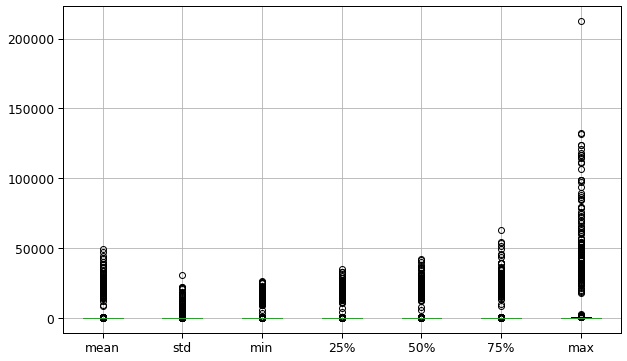

In [22]:
dfDVARSStats = dfDVARS.T.describe().T
dfDVARSStats.drop(columns='count').boxplot()

<AxesSubplot:>

(0.0, 200.0)

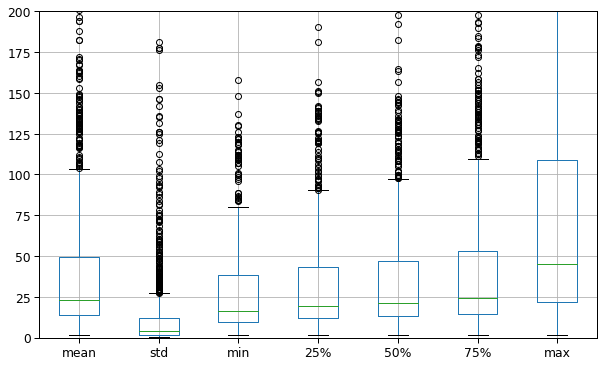

In [23]:
dfDVARSStats.drop(columns='count').boxplot()
plt.ylim(-0,200)

### remove scans based on the parameters
* FWD > .3
* geater than 50% of frames being censored (aka 50% of fames with a FWD over 50% = FWD median over .5mm)
* DVARS outliers (greater than 75%+1.5IQR

### Check DVARS first

In [24]:
dfDVARSOutlierLimits = dfDVARSStats.quantile(.75)+(dfDVARSStats.quantile(.75)-dfDVARSStats.quantile(.25))

In [25]:
dfDVARSOutlierLimits

count    263.000000
mean      85.633772
std       21.988640
min       67.249447
25%       74.779984
50%       80.447579
75%       91.675619
max      195.501460
dtype: float64

In [26]:
dfDVARSOutliers = dfDVARSStats>dfDVARSOutlierLimits

In [27]:
#number of subjects that have all outliers
dfDVARSOutliers[['mean','25%','50%','75%']].apply(all, axis=1).sum()

221

In [28]:
#number of subjects that have any outliers
dfDVARSOutliers = dfDVARSOutliers[dfDVARSOutliers[['mean','25%','50%','75%']].apply(any, axis=1)]
dfDVARSOutliers.shape[0]

266

In [29]:
#number of subjects that mean as an outlier
dfDVARSOutliers[['mean']].sum()

mean    257
dtype: int64

In [30]:
#as the numebers are so close, between any and mean, lets just drop all subjects that are outliers for DVARS

In [31]:
#number of subjects that failed DVARS outlier test for ABIDEI and II respectivley
dfDVARSOutliers[dfDVARSOutliers[['mean','25%','50%','75%']].apply(any, axis=1)].loc[idx[:,1,:,:,:]].shape[0]
dfDVARSOutliers[dfDVARSOutliers[['mean','25%','50%','75%']].apply(any, axis=1)].loc[idx[:,2,:,:,:]].shape[0]

74

192

In [32]:
#number of subjects that failed mean FWD > 0.3
dfFWDMeanFailed = dfFWDStats[dfFWDStats['mean']>0.3]
dfFWDMeanFailed.loc[idx[:,1,:,:,:]].shape[0]
dfFWDMeanFailed.loc[idx[:,2,:,:,:]].shape[0]

81

74

In [33]:
#number of subjects that failed mean FWD 50 > 0.5
dfFWDScrubFailed = dfFWDStats[dfFWDStats['50%']>0.3]
dfFWDScrubFailed.loc[idx[:,1,:,:,:]].shape[0]
dfFWDScrubFailed.loc[idx[:,2,:,:,:]].shape[0]

31

19

In [34]:
dfCullSubjects = pd.concat([dfDVARSOutliers.reset_index()[['subject','ABIDE']],
                          dfFWDMeanFailed.reset_index()[['subject','ABIDE']],
                          dfFWDScrubFailed.reset_index()[['subject','ABIDE']]])

In [35]:
dfCullSubjects = dfCullSubjects.drop_duplicates()
dfCullSubjects[dfCullSubjects['ABIDE']==1].shape[0]
dfCullSubjects[dfCullSubjects['ABIDE']==2].shape[0]

132

230

In [36]:
dfCullSubjects

,subject,ABIDE
0,28677,2
1,28679,2
2,28680,2
3,28685,2
4,28686,2
...,...,...
150,51358,1
151,51359,1
152,51361,1
153,51556,1


In [37]:
dfPassedSubjects = pd.DataFrame(columns = ['subject','abide','session','run','path'])
for [strSubject, strABIDE, strSession, strRun, strFWDPath], row in dfFWDStats.iterrows():
    dfFound = dfCullSubjects[(dfCullSubjects['subject']==strSubject)&(dfCullSubjects['subject']==strSubject)]
    if dfFound.shape[0] == 0:
        dfPassedSubjects = dfPassedSubjects.append(pd.Series({'subject':strSubject,
                                                              'abide':strABIDE,
                                                              'session':strSession,
                                                              'run':strRun,
                                                              'path':os.path.dirname(strFWDPath)
                                                             }
                                                            ),
                                                   ignore_index=True)


In [38]:
dfPassedSubjects[dfPassedSubjects['abide']==1].shape[0]
dfPassedSubjects[dfPassedSubjects['abide']==2].shape[0]

831

597

In [39]:
dfPassedSubjects

,subject,abide,session,run,path
0,28741,2,1,1,/archive/bioinformatics/DLLab/AlexTreacher/dat...
1,28742,2,1,1,/archive/bioinformatics/DLLab/AlexTreacher/dat...
2,28743,2,1,1,/archive/bioinformatics/DLLab/AlexTreacher/dat...
3,28744,2,1,1,/archive/bioinformatics/DLLab/AlexTreacher/dat...
4,28745,2,1,1,/archive/bioinformatics/DLLab/AlexTreacher/dat...
...,...,...,...,...,...
1423,51583,1,1,1,/archive/bioinformatics/DLLab/AlexTreacher/dat...
1424,51584,1,1,1,/archive/bioinformatics/DLLab/AlexTreacher/dat...
1425,51585,1,1,1,/archive/bioinformatics/DLLab/AlexTreacher/dat...
1426,51606,1,1,1,/archive/bioinformatics/DLLab/AlexTreacher/dat...


In [40]:
lFiles = [
    'sub-{}_ses-{}_task-rest_run-{}*_desc-1_space-EPI_alff.nii.gz',
    'sub-{}_ses-{}_task-rest_run-{}*_desc-2_space-EPI_alff.nii.gz',
    'sub-{}_ses-{}_task-rest_run-{}*_desc-3_space-EPI_alff.nii.gz',
    'sub-{}_ses-{}_task-rest_run-{}*_desc-1_space-EPI_falff.nii.gz',
    'sub-{}_ses-{}_task-rest_run-{}*_desc-2_space-EPI_falff.nii.gz',
    'sub-{}_ses-{}_task-rest_run-{}*_desc-3_space-EPI_falff.nii.gz',
    'sub-{}_ses-{}_task-rest_run-{}*_desc-1_space-EPI_reho.nii.gz',
    'sub-{}_ses-{}_task-rest_run-{}*_desc-2_space-EPI_reho.nii.gz',
    'sub-{}_ses-{}_task-rest_run-{}*_desc-3_space-EPI_reho.nii.gz',
]

In [41]:
#for each subject, get the fALFF and ReHo paths
for i, row in dfPassedSubjects.iterrows():
    for strFile in lFiles:
        if row['abide'] == 1:
            strSubject = '00'+row['subject']
        else:
            strSubject = row['subject']
        strPath = os.path.join(row['path'],strFile.format(strSubject,row['session'],row['run']))
        lPaths = glob.glob(strPath)
        #remove all derivative maps that have been converted into a different space
        #lPaths = [x for x in lPaths if 'space-EPI' in x]
        assert lPaths.__len__()==1
        strPath = lPaths[0]
        strCol = '_'.join(strFile.split('_')[-3:])
        dfPassedSubjects.loc[i, strCol] = strPath

In [42]:
dfPassedSubjects.to_csv(os.path.join(strOutputPath,'20210908_subject_motion_cull.csv'))

In [43]:
strOutputPath

'/archive/bioinformatics/DLLab/AlexTreacher/ExperimentOutputs/Autism_DCG'

In [44]:
strFile

'sub-{}_ses-{}_task-rest_run-{}*_desc-3_space-EPI_reho.nii.gz'